In [1]:
""" This notebook describes exploratory analyses of 2013 US vital
statistics data. These data are open access and publicly available.

Written by Laura Nolan

Created on 8/1/2015
Updated on 8/24/2015

"""

In [ ]:
import pandas as pd
import numpy as np
import psycopg2
import json
import re
from sqlalchemy import create_engine
from sklearn.linear_model import LogisticRegression
import itertools
import statsmodels.api as sm
import matplotlib as mpl
mpl.use('Agg')
import seaborn as sns
import math

%matplotlib inline

# Setting up connection 

In [2]:
params = json.load(open('psql_psycopg2.password'))

try:
    conn = psycopg2.connect(**params)
    conn.autocommit = True
    cur = conn.cursor()

except:
    print('Unable to connect to database')
    
import sys
sys.path.insert(0, '/home/lnolan/git_dir/babies')
from babysaver import features
from babysaver import models
from babysaver import evaluation


# Pulling in a sample of the vital statistics

In [3]:
# listing only features that are more or less present in 707G
vital_features = ['rf_diab_rec_c', 'rf_gest_rec_c', 'rf_phyp_rec_c', 'rf_ghyp_rec_c', 
            'rf_eclam_rec_c', 'rf_ppoutc_rec_c', 'rf_ppterm_rec_c', 'dplural_c', 
            'sexdis_rec_f', 'pay_rec_c', 'ip_gono_rec_c', 'ip_syph_rec_c',
            'ip_chlam_rec_c', 'ip_hepatb_rec_c', 'ip_hepatc_rec_c',
            'meduc_rec_n', 'cig_0_rec_n', 'cig_1_rec_n', 'cig_2_rec_n',
            'cig_3_rec_n', 'pay_rec_rec_c', 'pwgt_r_rec_n']
vital_outcome = "advb_otc"
vital_table = "vitals_all"

# Applying pipeline to vital statistics

In [6]:
df = features.general_data_getter(vital_features, vital_outcome, vital_table, n_rows=100000, conn = conn, create_ref=True)

data_getter: dataset has dimensions (81217, 33)


In [41]:
df['dataframe'].head()

,index,sexdis_rec_f,UNIQUE_ID_I,rf_diab_rec_c_Y,rf_gest_rec_c_Y,rf_phyp_rec_c_Y,rf_ghyp_rec_c_Y,rf_eclam_rec_c_Y,rf_ppoutc_rec_c_Y,rf_ppterm_rec_c_Y,...,pay_rec_rec_c_1,pay_rec_rec_c_4,pay_rec_rec_c_3,advb_otc,meduc_rec_n,cig_0_rec_n,cig_1_rec_n,cig_2_rec_n,cig_3_rec_n,pwgt_r_rec_n
0,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,-0.120947,-0.275209,-0.234142,-0.213524,-0.203926,-0.129174
1,1,0,2,0,0,0,1,0,0,0,...,1,0,0,1,-0.695180,-0.275209,-0.234142,-0.213524,-0.203926,-0.869456
2,2,0,3,0,0,0,0,0,0,0,...,0,0,0,1,-0.695180,-0.275209,-0.234142,-0.213524,-0.203926,0.240967
3,3,0,4,0,0,0,0,0,0,0,...,1,0,0,0,-0.695180,-0.275209,-0.234142,-0.213524,-0.203926,-0.252554
4,4,0,5,0,0,0,0,0,0,0,...,0,0,0,0,-0.120947,-0.275209,-0.234142,-0.213524,-0.203926,-0.474639


# Proportion of adverse births in the sample

In [7]:
print df['dataframe']['advb_otc'].mean()

0.170087543248


In [43]:
print df['features']

['sexdis_rec_f', 'meduc_rec_n', 'cig_0_rec_n', 'cig_1_rec_n', 'cig_2_rec_n', 'cig_3_rec_n', 'pwgt_r_rec_n', 'rf_diab_rec_c_Y', 'rf_gest_rec_c_Y', 'rf_phyp_rec_c_Y', 'rf_ghyp_rec_c_Y', 'rf_eclam_rec_c_Y', 'rf_ppoutc_rec_c_Y', 'rf_ppterm_rec_c_Y', 'dplural_c_2', 'dplural_c_3', 'dplural_c_4', 'dplural_c_5', 'pay_rec_c_1', 'pay_rec_c_4', 'pay_rec_c_3', 'pay_rec_c_9', 'ip_gono_rec_c_Y', 'ip_syph_rec_c_Y', 'ip_chlam_rec_c_Y', 'ip_hepatb_rec_c_Y', 'ip_hepatc_rec_c_Y', 'pay_rec_rec_c_1', 'pay_rec_rec_c_4', 'pay_rec_rec_c_3']


In [44]:
help(models.machine_learner)

Help on function machine_learner in module babysaver.models:

machine_learner(data_dct, clf_library, cv, make_evals=False, pkl_folder='pickles', verbose=False, eval_folder='evals', n_folds=5, stratified=True, bagging=False, test_size=0.3, increment=6, k=0.1, start_date=None, end_date=None, **kwargs)
    This function is customized for temporal cross-validation and 
    precision-at-k evaluation.
    
    data_dct - dictionary containing data, features, outcome from 
               features.data_getter() 
    clf_library - list of classifier dictionaries in following format
            {
                'clf': Classifier(),
                'param_dict': {
                    'param1': [list of parameter values],
                    'param2': [list of parameter values]
                } 
            }
    cv - specify type of cross-validation as string, current options are:
            'temporal_cv', 'train_test_split', 'kfold_cv'
    pkl_folder - folder to save pickle files 
    n_folds

# Specifying classifiers and running the pipeline

In [8]:
classifiers = {
    'clf': LogisticRegression,
    'param_dict': {
        'C': [0.001, 0.01, 1, 10],
        'penalty': ["l1", "l2"]
        }
    }

# only return the first item 
models_dict, pkl_dct = models.machine_learner(df, classifiers, "kfold_cv", k=[0.3])

You have not specified a folder for the pickle files. By default, they will be saved in ./pickles/ - do you want to continue? (y/n)y
machine_learner: finished running models
machine_learner: pickle files available in pickles/
machine_learner: total runtime was 0:00:29.226414


# Running evaluation

In [9]:
evaluation_df = evaluation.dict_to_dataframe(models_dict, pkl_dct)
pd.DataFrame(evaluation_df.sort('precision at 0.3 mean', ascending=False)['pickle_file'])

,pickle_file
"LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='ovr',\n penalty='l2', random_state=None, solver='liblinear', tol=0.0001,\n verbose=0)",pickles/LogisticRegression6.pkl
"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='ovr',\n penalty='l2', random_state=None, solver='liblinear', tol=0.0001,\n verbose=0)",pickles/LogisticRegression7.pkl
"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='ovr',\n penalty='l1', random_state=None, solver='liblinear', tol=0.0001,\n verbose=0)",pickles/LogisticRegression3.pkl
"LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='ovr',\n penalty='l1', random_state=None, solver='liblinear', tol=0.0001,\n verbose=0)",pickles/LogisticRegression2.pkl
"LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='ovr',\n penalty='l2', random_state=None, solver='liblinear', tol=0.0001,\n verbose=0)",pickles/LogisticRegression5.pkl
"LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='ovr',\n penalty='l1', random_state=None, solver='liblinear', tol=0.0001,\n verbose=0)",pickles/LogisticRegression1.pkl
"LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='ovr',\n penalty='l2', random_state=None, solver='liblinear', tol=0.0001,\n verbose=0)",pickles/LogisticRegression4.pkl
"LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='ovr',\n penalty='l1', random_state=None, solver='liblinear', tol=0.0001,\n verbose=0)",pickles/LogisticRegression0.pkl


In [10]:
pd.DataFrame(evaluation_df.sort('precision at 0.3 mean', ascending=False))

,avg_prec_score_mean,avg_prec_score_std,roc_auc_mean,roc_auc_std,avg_prec_0.3 mean,avg_prec_0.3 std,precision at 0.3 mean,precision at 0.3 std,recall at 0.3 mean,recall at 0.3 std,test_count at 0.3 mean,test_count at 0.3 std,test_percent at 0.3 mean,test_percent at 0.3 std,pickle_file
"LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='ovr',\n penalty='l2', random_state=None, solver='liblinear', tol=0.0001,\n verbose=0)",0.378021,0.007457,0.663657,0.003127,0.269703,0.009081,0.282492,0.003350,0.499710,0.009586,4887.2,73.431601,0.300873,0.004518,pickles/LogisticRegression6.pkl
"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='ovr',\n penalty='l2', random_state=None, solver='liblinear', tol=0.0001,\n verbose=0)",0.378342,0.007251,0.663673,0.003106,0.269986,0.008827,0.282329,0.003214,0.499420,0.009946,4887.2,79.728916,0.300873,0.004905,pickles/LogisticRegression7.pkl
"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='ovr',\n penalty='l1', random_state=None, solver='liblinear', tol=0.0001,\n verbose=0)",0.378449,0.007149,0.663674,0.003110,0.270113,0.008714,0.282317,0.003202,0.499420,0.009946,4887.4,79.077810,0.300885,0.004865,pickles/LogisticRegression3.pkl
"LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='ovr',\n penalty='l1', random_state=None, solver='liblinear', tol=0.0001,\n verbose=0)",0.378358,0.007259,0.663600,0.003288,0.269961,0.008865,0.282294,0.003491,0.499275,0.009590,4886.4,72.244723,0.300824,0.004445,pickles/LogisticRegression2.pkl
"LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='ovr',\n penalty='l2', random_state=None, solver='liblinear', tol=0.0001,\n verbose=0)",0.369120,0.007162,0.662346,0.003726,0.260471,0.009078,0.281483,0.003672,0.498624,0.010449,4894.2,89.569526,0.301304,0.005514,pickles/LogisticRegression5.pkl
"LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='ovr',\n penalty='l1', random_state=None, solver='liblinear', tol=0.0001,\n verbose=0)",0.362182,0.006804,0.655399,0.004709,0.252071,0.008438,0.276287,0.004459,0.487694,0.011941,4876.8,88.930872,0.300233,0.005474,pickles/LogisticRegression1.pkl
"LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='ovr',\n penalty='l2', random_state=None, solver='liblinear', tol=0.0001,\n verbose=0)",0.335543,0.007157,0.639589,0.005597,0.224703,0.008738,0.265253,0.004117,0.467714,0.009276,4871.6,62.970628,0.299913,0.003882,pickles/LogisticRegression4.pkl
"LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='ovr',\n penalty='l1', random_state=None, solver='liblinear', tol=0.0001,\n verbose=0)",0.315779,0.008254,0.613340,0.005141,0.184670,0.010284,0.216166,0.003262,0.571377,0.009519,7303.0,85.953476,0.449598,0.005284,pickles/LogisticRegression0.pkl


In [74]:
df['features']

['sexdis_rec_f',
 'meduc_rec_n',
 'cig_0_rec_n',
 'cig_1_rec_n',
 'cig_2_rec_n',
 'cig_3_rec_n',
 'pwgt_r_rec_n',
 'rf_diab_rec_c_Y',
 'rf_gest_rec_c_Y',
 'rf_phyp_rec_c_Y',
 'rf_ghyp_rec_c_Y',
 'rf_eclam_rec_c_Y',
 'rf_ppoutc_rec_c_Y',
 'rf_ppterm_rec_c_Y',
 'dplural_c_2',
 'dplural_c_3',
 'dplural_c_4',
 'dplural_c_5',
 'pay_rec_c_1',
 'pay_rec_c_4',
 'pay_rec_c_3',
 'pay_rec_c_9',
 'ip_gono_rec_c_Y',
 'ip_syph_rec_c_Y',
 'ip_chlam_rec_c_Y',
 'ip_hepatb_rec_c_Y',
 'ip_hepatc_rec_c_Y',
 'pay_rec_rec_c_1',
 'pay_rec_rec_c_4',
 'pay_rec_rec_c_3']

# Looking at coefficient importances

In [75]:
from sklearn.externals import joblib

lr = joblib.load('pickles/LogisticRegression1.pkl')
pd.DataFrame({'features': df['features'], 'coef': lr.coef_[0]})

,coef,features
0,0.000000,sexdis_rec_f
1,-0.107866,meduc_rec_n
2,0.000000,cig_0_rec_n
3,0.044208,cig_1_rec_n
4,0.031915,cig_2_rec_n
5,0.000000,cig_3_rec_n
6,-0.050275,pwgt_r_rec_n
7,0.000000,rf_diab_rec_c_Y
8,0.106340,rf_gest_rec_c_Y
9,0.456506,rf_phyp_rec_c_Y


In [76]:
pd.DataFrame({'features': df['features'], 'coef': lr.coef_[0]}).sort('coef')

,coef,features
1,-0.107866,meduc_rec_n
6,-0.050275,pwgt_r_rec_n
0,0.000000,sexdis_rec_f
26,0.000000,ip_hepatc_rec_c_Y
25,0.000000,ip_hepatb_rec_c_Y
24,0.000000,ip_chlam_rec_c_Y
23,0.000000,ip_syph_rec_c_Y
22,0.000000,ip_gono_rec_c_Y
21,0.000000,pay_rec_c_9
20,0.000000,pay_rec_c_3


# SWITCHING GEARS A BIT:
# Correlation matrix for vital statistics 
# Just the variables that roughly correspond to 707

In [77]:
vars707 = ['rf_diab_c_rec', 'rf_gest_c_rec', 'rf_phyp_c_rec', 'rf_ghyp_c_rec', 
            'rf_eclam_c_rec', 'rf_ppoutc_c_rec', 'rf_ppterm_c_rec', 'dplural_c',
            'sexdis_rec_f', 'meduc_rec_n', 'cig_0_rec_n', 'cig_1_rec_n', 
            'cig_2_rec_n', 'cig_3_rec_n', 'pay_rec_rec_c', 'advb_otc']
            
# initializing pandas data frame with the new_cols_list title - basically building an empty correlation matrix
ORs= pd.DataFrame(data=None, index=vars707, columns=vars707)
ORs.head()

,rf_diab_c_rec,rf_gest_c_rec,rf_phyp_c_rec,rf_ghyp_c_rec,rf_eclam_c_rec,rf_ppoutc_c_rec,rf_ppterm_c_rec,dplural_c,sexdis_rec_f,meduc_rec_n,cig_0_rec_n,cig_1_rec_n,cig_2_rec_n,cig_3_rec_n,pay_rec_rec_c,advb_otc
rf_diab_c_rec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rf_gest_c_rec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rf_phyp_c_rec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rf_ghyp_c_rec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rf_eclam_c_rec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Load from postgres

In [ ]:
for_heatmap = pd.read_sql('SELECT rf_diab_c_rec, rf_gest_c_rec, rf_phyp_c_rec, rf_ghyp_c_rec,' + 
            'rf_eclam_c_rec, rf_ppoutc_c_rec, rf_ppterm_c_rec, dplural_c,' 
            'sexdis_rec_f, meduc_rec_n, cig_0_rec_n, cig_1_rec_n,' +
            'cig_2_rec_n, cig_3_rec_n, pay_rec_rec_c, pwgt_r_rec_n, advb_otc FROM forheatmap ORDER BY RANDOM() LIMIT 100000', conn)

In [79]:
# Checking types - some things will need to be recast
[(for_heatmap[i].dtype,i) for i in for_heatmap.columns.values]

[(dtype('float64'), 'rf_diab_c_rec'),
 (dtype('float64'), 'rf_gest_c_rec'),
 (dtype('float64'), 'rf_phyp_c_rec'),
 (dtype('float64'), 'rf_ghyp_c_rec'),
 (dtype('float64'), 'rf_eclam_c_rec'),
 (dtype('float64'), 'rf_ppoutc_c_rec'),
 (dtype('float64'), 'rf_ppterm_c_rec'),
 (dtype('O'), 'dplural_c'),
 (dtype('float64'), 'sexdis_rec_f'),
 (dtype('float64'), 'meduc_rec_n'),
 (dtype('float64'), 'cig_0_rec_n'),
 (dtype('float64'), 'cig_1_rec_n'),
 (dtype('float64'), 'cig_2_rec_n'),
 (dtype('float64'), 'cig_3_rec_n'),
 (dtype('O'), 'pay_rec_rec_c'),
 (dtype('float64'), 'pwgt_r_rec_n'),
 (dtype('float64'), 'advb_otc')]

In [80]:
# making sure that everything is a float

for_heatmap[['dplural_c', 'pay_rec_rec_c']] = for_heatmap[['dplural_c', 'pay_rec_rec_c']].astype(float)

In [81]:
# looking at all variables to see distribution
print "rf_diab_c_rec"
print for_heatmap['rf_diab_c_rec'].value_counts(dropna = False)
print "rf_gest_c_rec"
print for_heatmap['rf_gest_c_rec'].value_counts(dropna = False)
print "rf_gest_c_rec"
print for_heatmap['rf_gest_c_rec'].value_counts(dropna = False)
print "rf_phyp_c_rec"
print for_heatmap['rf_phyp_c_rec'].value_counts(dropna = False)
print "rf_ghyp_c_rec"
print for_heatmap['rf_ghyp_c_rec'].value_counts(dropna = False)
print "rf_eclam_c_rec"
print for_heatmap['rf_eclam_c_rec'].value_counts(dropna = False)
print "rf_ppoutc_c_rec"
print for_heatmap['rf_ppoutc_c_rec'].value_counts(dropna = False)
print "rf_ppterm_c_rec"
print for_heatmap['rf_ppterm_c_rec'].value_counts(dropna = False)
print "dplural_c" # NEEDS TO BE RECODED TO >1
print for_heatmap['dplural_c'].value_counts(dropna = False)
print "sexdis_rec_f"
print for_heatmap['sexdis_rec_f'].value_counts(dropna = False)
print "meduc_rec_n" # NEEDS TO BE RECODED TO (probably) more than high school, etc.
print for_heatmap['meduc_rec_n'].value_counts(dropna = False)
print "cig_0_rec_n"
print for_heatmap['cig_0_rec_n'].value_counts(dropna = False)

rf_diab_c_rec
 0     89515
NaN     9778
 1       707
dtype: int64
rf_gest_c_rec
 0     85484
NaN     9778
 1      4738
dtype: int64
rf_gest_c_rec
 0     85484
NaN     9778
 1      4738
dtype: int64
rf_phyp_c_rec
 0     88873
NaN     9778
 1      1349
dtype: int64
rf_ghyp_c_rec
 0     85759
NaN     9778
 1      4463
dtype: int64
rf_eclam_c_rec
 0     90024
NaN     9778
 1       198
dtype: int64
rf_ppoutc_c_rec
 0     88213
NaN     9778
 1      2009
dtype: int64
rf_ppterm_c_rec
 0     87839
NaN     9778
 1      2383
dtype: int64
dplural_c
1    96518
2     3347
3      127
4        6
5        2
dtype: int64
sexdis_rec_f
 0     88235
NaN     9544
 1      2221
dtype: int64
meduc_rec_n
 3     22288
 4     19080
 6     16889
 2     10763
NaN    10627
 7      7502
 5      7158
 1      3476
 8      2217
dtype: int64
cig_0_rec_n
 0     76547
NaN    13922
 20     2975
 10     2595
 5       942
 3       481
 2       354
 4       353
 6       264
 40      258
 1       256
 15      242
 7       179
 

In [82]:
# checking on how many missings there are for an often missing variables
for_heatmap['rf_diab_c_rec'].value_counts(dropna = False)

 0     89515
NaN     9778
 1       707
dtype: int64

In [83]:
for_heatmap.head()
# dropping na's
for_heatmap_complete = for_heatmap.dropna()
for_heatmap_complete.head()

,rf_diab_c_rec,rf_gest_c_rec,rf_phyp_c_rec,rf_ghyp_c_rec,rf_eclam_c_rec,rf_ppoutc_c_rec,rf_ppterm_c_rec,dplural_c,sexdis_rec_f,meduc_rec_n,cig_0_rec_n,cig_1_rec_n,cig_2_rec_n,cig_3_rec_n,pay_rec_rec_c,pwgt_r_rec_n,advb_otc
0,0,0,0,0,0,0,0,1,0,4,0,0,0,0,2,139,0
2,0,0,0,0,0,0,0,1,0,4,0,0,0,0,1,125,0
3,0,0,0,0,0,0,0,1,0,2,0,0,0,0,1,130,1
5,0,0,0,0,0,0,0,1,0,3,5,4,0,0,1,145,0
6,0,0,0,0,0,0,0,1,0,3,0,0,0,0,4,147,0


In [84]:
len(for_heatmap_complete) # quickly checking sample size

81009

# Recoding whether there is more than 1 fetus

In [ ]:
def babynum(f):
    if f > 1:
        return 1
    else: 
        return 0

dplural_c_dum = [1 if int(x) > 1 else 0 for x in for_heatmap_complete['dplural_c']]

In [86]:
type(for_heatmap_complete['dplural_c'][0]) # checking type...

numpy.float64

# Recoding mother's education to 0/1

In [ ]:
def meduc_rec(f):
    if f < 3:
        return 1
    else:
        return 0

meduc_rec_n_dum = [meduc_rec(x) for x in for_heatmap_complete['meduc_rec_n']]

# Recoding cigs

In [ ]:
def cigs(f):
    if f > 0:
        return 1
    else:
        return 0
    
cig_0_rec_n_dum = [cigs(x) for x in for_heatmap_complete['cig_0_rec_n']]
cig_1_rec_n_dum = [cigs(x) for x in for_heatmap_complete['cig_1_rec_n']]
cig_2_rec_n_dum = [cigs(x) for x in for_heatmap_complete['cig_2_rec_n']]
cig_3_rec_n_dum = [cigs(x) for x in for_heatmap_complete['cig_3_rec_n']]

# Recoding payment method - 1 is Medicaid

In [ ]:
def pay(f):
    if f == 1:
        return 1
    else: 
        return 0

pay_rec_rec_c_dum = [pay(x) for x in for_heatmap_complete['pay_rec_rec_c']]

In [90]:
type(cig_3_rec_n_dum) # the recoded vars are in list format

list

In [91]:
# Getting all vars, including recoded, into one data frame

test = pd.DataFrame({'cigs_before_preg': cig_0_rec_n_dum,
        'cigs_in_first_tri': cig_1_rec_n_dum,
        'cigs_in_second_tri': cig_2_rec_n_dum,
        'cigs_in_third_tri': cig_3_rec_n_dum,
        'medicaid_payer': pay_rec_rec_c_dum,
        'diabetes': for_heatmap_complete['rf_diab_c_rec'],
        'gestational_diab': for_heatmap_complete['rf_gest_c_rec'],
        'prepreg_hyp': for_heatmap_complete['rf_phyp_c_rec'],
        'gest_hyp': for_heatmap_complete['rf_ghyp_c_rec'],
        'ecclampsia': for_heatmap_complete['rf_eclam_c_rec'],
        'poor_prev_preg_out': for_heatmap_complete['rf_ppoutc_c_rec'],
        'previous_preterm': for_heatmap_complete['rf_ppterm_c_rec'],
        'multi_fetus': dplural_c_dum,
        'sexually_trans_dis': for_heatmap_complete['sexdis_rec_f'],
        'advb_otc': for_heatmap_complete['advb_otc']})

test.head()

,advb_otc,cigs_before_preg,cigs_in_first_tri,cigs_in_second_tri,cigs_in_third_tri,diabetes,ecclampsia,gest_hyp,gestational_diab,medicaid_payer,multi_fetus,poor_prev_preg_out,prepreg_hyp,previous_preterm,sexually_trans_dis
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [92]:
# all pairs of columns
varsformap = ['cigs_before_preg', 'cigs_in_first_tri', 'cigs_in_second_tri', 'cigs_in_third_tri',
             'medicaid_payer', 'diabetes', 'gestational_diab', 'prepreg_hyp', 'gest_hyp', 'ecclampsia',
             'poor_prev_preg_out', 'previous_preterm', 'multi_fetus', 'sexually_trans_dis', 'advb_otc']
forints = list(itertools.combinations(varsformap, 2))
 
# creating the shell for the correlation matrix
phis = pd.DataFrame(data=None, index=varsformap, columns=varsformap)
phis.head()

,cigs_before_preg,cigs_in_first_tri,cigs_in_second_tri,cigs_in_third_tri,medicaid_payer,diabetes,gestational_diab,prepreg_hyp,gest_hyp,ecclampsia,poor_prev_preg_out,previous_preterm,multi_fetus,sexually_trans_dis,advb_otc
cigs_before_preg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cigs_in_first_tri,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cigs_in_second_tri,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cigs_in_third_tri,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
medicaid_payer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Defining a function to compute the phi correlation (a measure of association for two binary variables)

In [ ]:
import math
def phi(thingy):
    num = (thingy[1,1]*thingy[0,0]) - (thingy[1][0]*thingy[0][1])
    denom = math.sqrt(thingy[2,1]*thingy[2,0]*thingy[0,2]*thingy[1,2])
    return num/denom

In [94]:
# computing the correlation and appending it to the empty data frame

for comb in forints:
    mini = test[[comb[0], comb[1]]]
    thingy = pd.crosstab(test[comb[0]], test[comb[1]], margins = True)
    thingy = np.array(thingy)
    #print phi(thingy)
    phi_corr = phi(thingy)
    phis.loc[comb[1], comb[0]] = phi_corr

test = test.fillna(value=0)

print phis.head()

                   cigs_before_preg cigs_in_first_tri cigs_in_second_tri  \
cigs_before_preg                NaN               NaN                NaN   
cigs_in_first_tri         0.8388118               NaN                NaN   
cigs_in_second_tri         0.774751         0.9066412                NaN   
cigs_in_third_tri         0.7513074         0.8689686          0.9440565   
medicaid_payer            0.1683236          0.173997           0.172581   

                   cigs_in_third_tri medicaid_payer diabetes gestational_diab  \
cigs_before_preg                 NaN            NaN      NaN              NaN   
cigs_in_first_tri                NaN            NaN      NaN              NaN   
cigs_in_second_tri               NaN            NaN      NaN              NaN   
cigs_in_third_tri                NaN            NaN      NaN              NaN   
medicaid_payer             0.1688268            NaN      NaN              NaN   

                   prepreg_hyp gest_hyp ecclampsia poor_

In [95]:
# another option is to compute the odds ratios from bivariate logististic regression models 
# for comb in forints:
    # print comb[0], comb[1]
    # logit = sm.Logit(test[comb[0]], test[comb[1]])
    # result = logit.fit()
    # OR = np.exp(result.params)[0] # extracting just odds ratio
    # ORs.loc[comb[1], comb[0]] = OR

# Plotting a heat map of the phi correlations

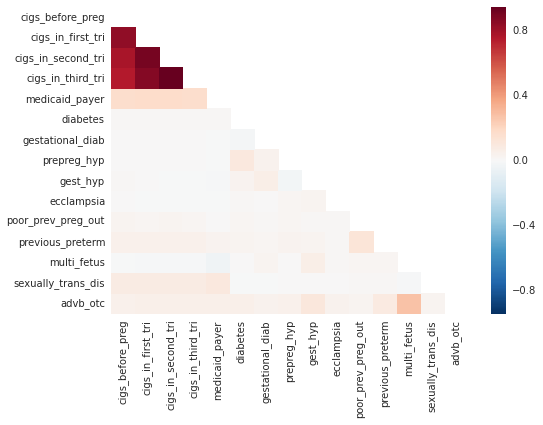

In [96]:
sns.set(style="white")

# replace NAs with 0 - or else heat map will not run
phis = phis.fillna(value=0)

# Generate a mask for the upper triangle
mask = np.zeros_like(phis, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

pic = sns.heatmap(phis, mask=mask, xticklabels=varsformap, yticklabels=varsformap)

# Rerunning pipeline just with women whose birth was paid for by Medicaid

In [13]:
# listing only features that are more or less present in 707G
vital_features = ['rf_diab_rec_c', 'rf_phyp_rec_c',
            'rf_ppoutc_rec_c', 'rf_ppterm_rec_c', 'dplural_c', 
            'sexdis_rec_f', 'ip_gono_rec_c', 'ip_syph_rec_c',
            'ip_chlam_rec_c', 'ip_hepatb_rec_c', 'ip_hepatc_rec_c',
            'meduc_rec_n', 'cig_0_rec_n', 'cig_1_rec_n', 'cig_2_rec_n',
            'cig_3_rec_n', 'pay_rec_rec_c', 'pwgt_r_rec_n']
vital_outcome = "advb_otc"
vital_table = "justMedicaid"
                  
                  # not fair to include things during preg: 'rf_gest_rec_c', 'rf_ghyp_rec_c', 'rf_eclam_rec_c'

df = features.general_data_getter(vital_features, vital_outcome, vital_table, n_rows=100000, conn = conn, create_ref=True)

classifiers = {
    'clf': LogisticRegression,
    'param_dict': {
        'C': [0.001, 0.01, 1, 10],
        'penalty': ["l1", "l2"]
        }
    }

# only return the first item 
models_dict, pkl_dct = models.machine_learner(df, classifiers, "kfold_cv", k=[0.1])


evaluation_df = evaluation.dict_to_dataframe(models_dict, pkl_dct)
pd.DataFrame(evaluation_df.sort('precision at 0.1 mean', ascending=False)['pickle_file'])

data_getter: dataset has dimensions (90647, 22)
You have not specified a folder for the pickle files. By default, they will be saved in ./pickles/ - do you want to continue? (y/n)y
machine_learner: finished running models
machine_learner: pickle files available in pickles/
machine_learner: total runtime was 0:00:16.470830


,pickle_file
"LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='ovr',\n penalty='l1', random_state=None, solver='liblinear', tol=0.0001,\n verbose=0)",pickles/LogisticRegression2.pkl
"LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='ovr',\n penalty='l2', random_state=None, solver='liblinear', tol=0.0001,\n verbose=0)",pickles/LogisticRegression6.pkl
"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='ovr',\n penalty='l2', random_state=None, solver='liblinear', tol=0.0001,\n verbose=0)",pickles/LogisticRegression7.pkl
"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='ovr',\n penalty='l1', random_state=None, solver='liblinear', tol=0.0001,\n verbose=0)",pickles/LogisticRegression3.pkl
"LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='ovr',\n penalty='l2', random_state=None, solver='liblinear', tol=0.0001,\n verbose=0)",pickles/LogisticRegression5.pkl
"LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='ovr',\n penalty='l1', random_state=None, solver='liblinear', tol=0.0001,\n verbose=0)",pickles/LogisticRegression1.pkl
"LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='ovr',\n penalty='l2', random_state=None, solver='liblinear', tol=0.0001,\n verbose=0)",pickles/LogisticRegression4.pkl
"LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='ovr',\n penalty='l1', random_state=None, solver='liblinear', tol=0.0001,\n verbose=0)",pickles/LogisticRegression0.pkl


In [14]:
pd.DataFrame(evaluation_df.sort('precision at 0.1 mean', ascending=False))

,avg_prec_score_mean,avg_prec_score_std,roc_auc_mean,roc_auc_std,avg_prec_0.1 mean,avg_prec_0.1 std,precision at 0.1 mean,precision at 0.1 std,recall at 0.1 mean,recall at 0.1 std,test_count at 0.1 mean,test_count at 0.1 std,test_percent at 0.1 mean,test_percent at 0.1 std,pickle_file
"LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='ovr',\n penalty='l1', random_state=None, solver='liblinear', tol=0.0001,\n verbose=0)",0.348052,0.004442,0.605928,0.004647,0.152348,0.005087,0.434872,0.008406,0.225413,0.003993,1812.6,48.839533,0.099981,0.002693,pickles/LogisticRegression2.pkl
"LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='ovr',\n penalty='l2', random_state=None, solver='liblinear', tol=0.0001,\n verbose=0)",0.347984,0.004480,0.605935,0.004620,0.152329,0.005042,0.434680,0.008300,0.225413,0.003709,1813.4,47.715825,0.100025,0.002631,pickles/LogisticRegression6.pkl
"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='ovr',\n penalty='l2', random_state=None, solver='liblinear', tol=0.0001,\n verbose=0)",0.348175,0.004478,0.605925,0.004604,0.152544,0.005132,0.434585,0.008248,0.225413,0.003816,1813.8,48.473704,0.100047,0.002673,pickles/LogisticRegression7.pkl
"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='ovr',\n penalty='l1', random_state=None, solver='liblinear', tol=0.0001,\n verbose=0)",0.348228,0.004510,0.605924,0.004606,0.152574,0.005171,0.434458,0.008115,0.225299,0.003914,1813.4,48.982650,0.100025,0.002701,pickles/LogisticRegression3.pkl
"LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='ovr',\n penalty='l2', random_state=None, solver='liblinear', tol=0.0001,\n verbose=0)",0.343962,0.003745,0.604942,0.004906,0.148214,0.003327,0.429988,0.010114,0.222266,0.003646,1807.8,50.514354,0.099716,0.002785,pickles/LogisticRegression5.pkl
"LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='ovr',\n penalty='l1', random_state=None, solver='liblinear', tol=0.0001,\n verbose=0)",0.338083,0.003234,0.598966,0.005718,0.144032,0.002288,0.418889,0.009191,0.217118,0.003660,1812.4,38.240031,0.099970,0.002108,pickles/LogisticRegression1.pkl
"LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='ovr',\n penalty='l2', random_state=None, solver='liblinear', tol=0.0001,\n verbose=0)",0.325776,0.005685,0.599898,0.005309,0.130053,0.005297,0.409786,0.008017,0.211797,0.003723,1807.0,25.855367,0.099672,0.001426,pickles/LogisticRegression4.pkl
"LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='ovr',\n penalty='l1', random_state=None, solver='liblinear', tol=0.0001,\n verbose=0)",0.282969,0.017664,0.563666,0.003541,0.074025,0.020642,0.365911,0.007483,0.192632,0.007835,1840.6,73.717705,0.101526,0.004068,pickles/LogisticRegression0.pkl


In [17]:
from sklearn.externals import joblib

lr = joblib.load('pickles/LogisticRegression1.pkl')
pd.DataFrame({'features': df['features'], 'coef': lr.coef_[0]}).sort('coef')

,coef,features
6,-0.048390,pwgt_r_rec_n
1,-0.045012,meduc_rec_n
18,0.000000,ip_hepatc_rec_c_Y
16,0.000000,ip_chlam_rec_c_Y
15,0.000000,ip_syph_rec_c_Y
14,0.000000,ip_gono_rec_c_Y
5,0.000000,cig_3_rec_n
13,0.000000,dplural_c_4
12,0.000000,dplural_c_3
17,0.000000,ip_hepatb_rec_c_Y
